In [2]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt

from model.Unet.Unet import UNet
from utils.diffeo_container import sparse_diffeo_container
from utils.inverse_diffeo import find_param_inverse
from utils.get_model_activation import retrieve_layer_activation

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [3]:
trained_dict = torch.load('scratch_data/Unet_weights/1540k/model_weights_9_new.pth', map_location=device, weights_only = False)
denoiser = UNet(trained_dict['model_config'])
denoiser.load_state_dict(trained_dict['model_state_dict'])
denoiser.eval()
for param in denoiser.parameters():
    param.requires_grad = False
denoiser = denoiser.to(device)

In [3]:
vision_model = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT)
vision_model.eval();
for param in vision_model.parameters():
    param.requires_grad = False
vision_model = vision_model.to(device)
inference_transform = tv.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()
dataset = tv.datasets.ImageNet('/imagenet', split = 'val', transform = inference_transform)
test_image = dataset[38584][0].squeeze(0).to(device)

In [4]:
def get_diffeo_container(x_range, y_range, 
                         num_of_terms, 
                         diffeo_strength_list = None, 
                         num_of_didffeo = None, 
                         res = None,
                         device = torch.device('cpu')) -> sparse_diffeo_container:
  
  diffeo_container = sparse_diffeo_container(res, res)
  for strength in diffeo_strength_list:
      diffeo_container.sparse_AB_append(x_range, y_range, num_of_terms, strength, num_of_didffeo)
  diffeo_container.get_all_grid()
  diffeo_container.to(device)

  return diffeo_container

def get_inv_diffeo_container(diffeo_container: sparse_diffeo_container, 
                             res = 224, 
                             device = torch.device("cpu"), 
                             **kwargs) -> tuple[sparse_diffeo_container, list, list]:
  
  AB = torch.stack([(diffeo_container.A[0]), (diffeo_container.B[0])])
  [A_inv, B_inv], loss_hist, mag_hist = find_param_inverse(AB, device = device, resolution=res, **kwargs)
  inv_diffeos = sparse_diffeo_container(res, res, 
                                      A = [A_inv.cpu()], B = [B_inv.cpu()])
  inv_diffeos.get_all_grid()
  inv_diffeos.to(device)

  return inv_diffeos, loss_hist, mag_hist

In [5]:
x_range = y_range = [0,3]
number_of_non_zero_diffeo_parameter = 3
diffeo_strength = [0.2]
total_number_of_random_diffeos = 1
diffeo_sample_num = 1
blurry_resolution = 192

diffeos = get_diffeo_container(x_range, 
                                y_range, 
                                number_of_non_zero_diffeo_parameter, 
                                diffeo_strength,
                                total_number_of_random_diffeos,
                                blurry_resolution,
                                device = device)

inv_diffeos,_,_ = get_inv_diffeo_container(diffeos, res = blurry_resolution, device = device)

In [6]:
activation, _ = retrieve_layer_activation(vision_model, test_image, [5])
activation = activation[5]

Text(0.5, 1.0, 'original')

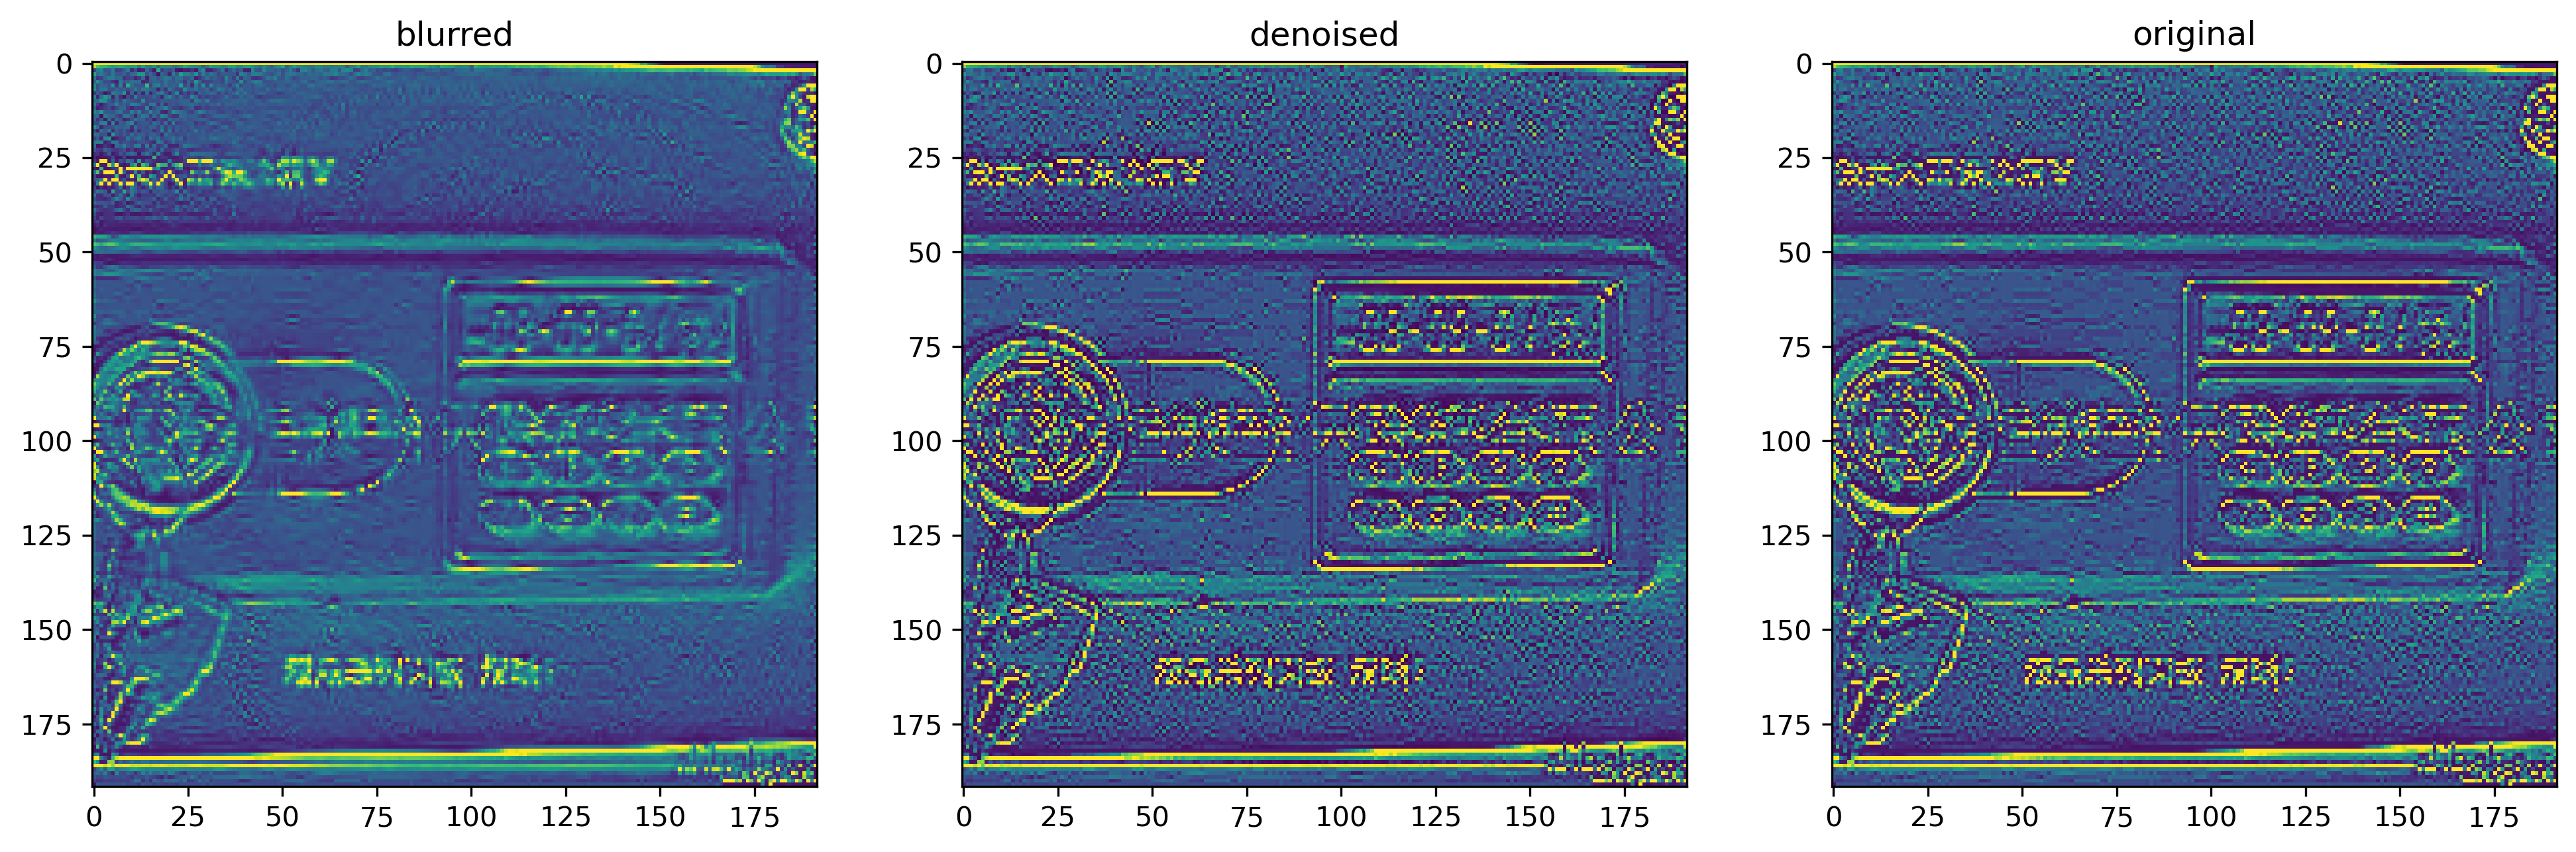

In [ ]:
channel_num = -1

blurred = inv_diffeos(diffeos(activation).squeeze(0)).squeeze(0)
denoised = denoiser(blurred[:,channel_num].unsqueeze(0))
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(16,48), dpi = 300) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(blurred[0,channel_num].squeeze().cpu(), vmin = -1, vmax = 15)
axarr[1].imshow(denoised[0].squeeze().cpu(), vmin = -1, vmax = 15)
axarr[2].imshow(activation[0,channel_num].cpu(), vmin = -1, vmax = 15)
axarr[0].set_title('blurred')
axarr[1].set_title('denoised')
axarr[2].set_title('original')

In [45]:
for channel_num in range(24):
    print(loss_fn(denoiser(activation[:,channel_num].unsqueeze(0)).squeeze(), activation[0,channel_num]))
    print(loss_fn(denoiser(blurred[:,channel_num].unsqueeze(0)).squeeze(), activation[0,channel_num]))
    print(loss_fn((blurred[:,channel_num].unsqueeze(0)).squeeze(), activation[0,channel_num]))

tensor(0.8637, device='cuda:0')
tensor(1.8571, device='cuda:0')
tensor(8.3631, device='cuda:0')
tensor(0.0566, device='cuda:0')
tensor(0.0398, device='cuda:0')
tensor(0.0758, device='cuda:0')
tensor(0.5217, device='cuda:0')
tensor(0.7818, device='cuda:0')
tensor(2.3321, device='cuda:0')
tensor(0.8702, device='cuda:0')
tensor(1.1463, device='cuda:0')
tensor(4.1690, device='cuda:0')
tensor(0.6565, device='cuda:0')
tensor(1.4216, device='cuda:0')
tensor(7.3856, device='cuda:0')
tensor(0.5437, device='cuda:0')
tensor(1.8331, device='cuda:0')
tensor(5.9989, device='cuda:0')
tensor(0.6014, device='cuda:0')
tensor(0.7711, device='cuda:0')
tensor(3.4590, device='cuda:0')
tensor(0.1561, device='cuda:0')
tensor(0.1293, device='cuda:0')
tensor(0.5986, device='cuda:0')
tensor(0.4566, device='cuda:0')
tensor(0.7633, device='cuda:0')
tensor(2.2107, device='cuda:0')
tensor(0.0318, device='cuda:0')
tensor(0.0238, device='cuda:0')
tensor(0.0203, device='cuda:0')
tensor(1.0938, device='cuda:0')
tensor(1